# Check pytorch,cuda & cudnn version

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

In [ ]:
print(torch.backends.cudnn.is_available())
print(torch.backends.cudnn.version()) 

# Evolution

In [ ]:
from sklearn.metrics import confusion_matrix

actual = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
predicted = [1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
print(tn, fp, fn, tp)

In [ ]:
Accuracy = (tp+tn)/(tp+fp+fn+tn)
Precision = tp/(tp+fp)
Recall= tp/(tp+fn)
print(Accuracy, Precision, Recall)

In [ ]:
F1 = 2 / ( (1/ Precision) + (1/ Recall) )
print(F1)

# Adjust image

In [1]:
from dataset import OD_Dataset
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from reinforcement import modify_image

trainDataset = OD_Dataset("Pascal_2012")
trainDataloader = DataLoader(trainDataset, batch_size=1, shuffle=True)

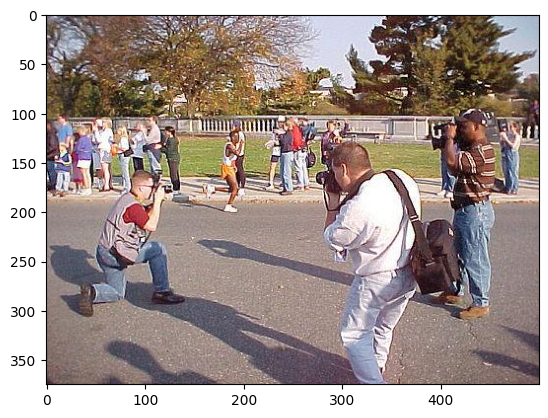

In [21]:
image, target, image_path = next(iter(trainDataloader))
image = image.squeeze(dim=0)
target = target.squeeze(dim=0)
labels, boxs = target[:, 0], target[:, 1:]
plt.imshow(TF.to_pil_image(image))
plt.show()

In [41]:
bright_img = TF.adjust_brightness(image, brightness_factor=1.5)
pil_img_1 = TF.to_pil_image(bright_img)

saturation_img = TF.adjust_saturation(image, saturation_factor=1.5)
pil_img_2 = TF.to_pil_image(saturation_img)

contrast_img = TF.adjust_contrast(image, contrast_factor=1.5)
pil_img_3 = TF.to_pil_image(contrast_img)

sharpness_img = TF.adjust_sharpness(image, sharpness_factor=1.5)
pil_img_4 = TF.to_pil_image(sharpness_img)

In [39]:
a = TF.adjust_saturation(image, saturation_factor=1.5)
b = TF.adjust_contrast(a, contrast_factor=1.5)
c = TF.adjust_brightness(b, brightness_factor=1.5)
d = TF.adjust_sharpness(c, sharpness_factor=1.5)
result_img = TF.to_pil_image(d)

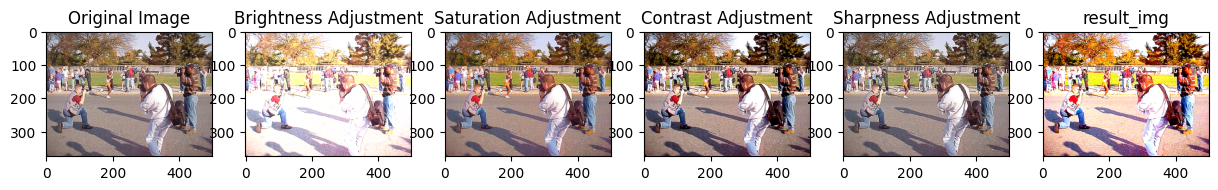

In [42]:
fig, axs = plt.subplots(1, 6, figsize=(15, 6))

axs[0].imshow(TF.to_pil_image(image))
axs[0].set_title('Original Image')
axs[1].imshow(pil_img_1)
axs[1].set_title('Brightness Adjustment')
axs[2].imshow(pil_img_2)
axs[2].set_title('Saturation Adjustment')
axs[3].imshow(pil_img_3)
axs[3].set_title('Contrast Adjustment')
axs[4].imshow(pil_img_4)
axs[4].set_title('Sharpness Adjustment')
axs[5].imshow(result_img)
axs[5].set_title('result_img')

plt.show()

In [43]:
from reinforcement import distortion_image
t = distortion_image(image)
t_img = TF.to_pil_image(t)

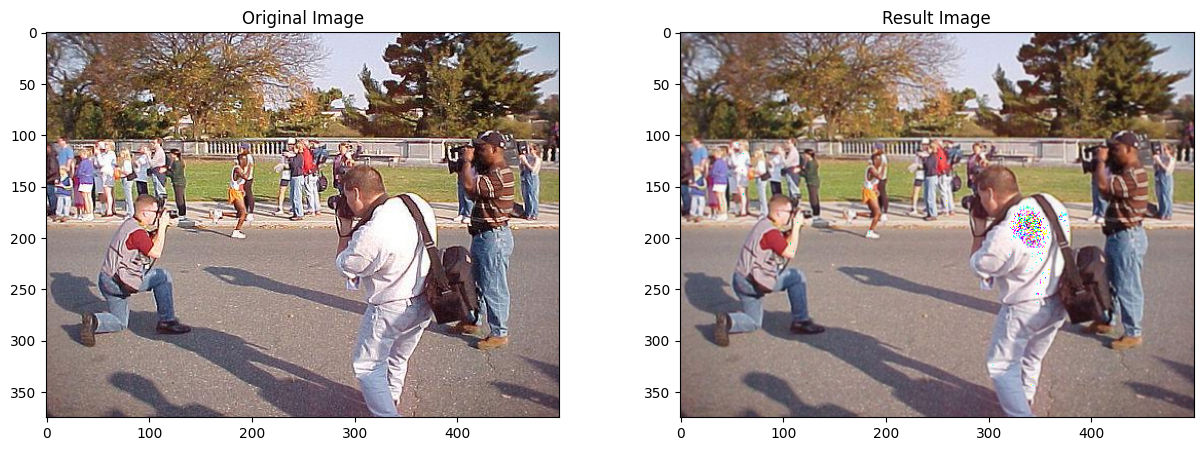

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].imshow(TF.to_pil_image(image))
axs[0].set_title('Original Image')
axs[1].imshow(t_img)
axs[1].set_title('Result Image')

plt.show()

# Test

In [ ]:
def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """
    import torch
    
    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

In [ ]:
def bbox_to_rect(bbox, color):
    '''
        bbox : (xmin, ymin, xmax, ymax)
        color: blue, red, etc
    '''
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]),      
        width=bbox[2]-bbox[0],      
        height=bbox[3]-bbox[1],     
        fill=False,             
        edgecolor=color,
        linewidth=2
    )

In [ ]:
def drawImageWithBox(image, labels, boxes):

    def get_classes(classes_path):
        import yaml
        with open(classes_path, 'r') as f:
            params = yaml.safe_load(f)
        names = params['names']
        count = len(names)
        return names, count
    
    from PIL import ImageDraw, ImageFont
    import torch
    import numpy as np
    import colorsys
    class_names, num_classes = get_classes("coco/data.yaml")
    font        = ImageFont.truetype(font='models/simhei.ttf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness   = int(max((image.size[0] + image.size[1]) // np.mean([640, 640]), 1))

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.numpy()

    for i, c in list(enumerate(labels)):
        predicted_class = class_names[int(c)]
        box             = boxes[i]

        # (xmin, ymin, xmax, ymax) -> (ymin, xmin, ymax, xmax)
        box[[1, 0, 3, 2]] = box[[0, 1, 2, 3]]
        top, left, bottom, right = box

        top     = max(0, np.floor(top).astype('int32'))
        left    = max(0, np.floor(left).astype('int32'))
        bottom  = min(image.size[1], np.floor(bottom).astype('int32'))
        right   = min(image.size[0], np.floor(right).astype('int32'))

        label = '{}'.format(predicted_class)
        draw = ImageDraw.Draw(image)
        
        # 使用 textbbox 來計算 label 的大小
        label_bbox = draw.textbbox((0, 0), label, font)
        label_width = label_bbox[2] - label_bbox[0]
        label_height = label_bbox[3] - label_bbox[1]
        
        label = label.encode('utf-8')
        
        if top - label_height >= 0:
            text_origin = np.array([left, top - label_height])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + (label_width, label_height))], fill=colors[c])
        draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
        del draw

    return image

In [ ]:
from dataset import OD_Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from reinforcement import modify_image

trainDataset = OD_Dataset("coco")
trainDataloader = DataLoader(trainDataset, batch_size=1, shuffle=True)

from yolo import YOLO
yolo = YOLO()

In [ ]:
data, target = next(iter(trainDataloader))
labels, boxs = target["labels"].squeeze(dim=0), target["boxes"].squeeze(dim=0)
image = data.squeeze(dim=0)
pil_img_0 = TF.to_pil_image(image)
result_image = yolo.detect_image(pil_img_0.copy())
groundTrue_image = drawImageWithBox(pil_img_0.copy(), labels, boxs)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(result_image)
axs[0].set_title('result_image')
axs[1].imshow(groundTrue_image)
axs[1].set_title('groundTrue_image')

In [ ]:
yolo.detectImg(image, target)

# Test-1

In [ ]:
from utils.datasets import LoadImages
import matplotlib.pyplot as plt
from PIL import Image
import cv2

dataset = LoadImages("inference/images/zidane.jpg", img_size=640, stride=32)

In [ ]:
path, img, im0s, vid_cap = next(iter(dataset))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cv2.cvtColor(im0s, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(img.transpose(1, 2, 0))
axs[1].set_title('modify Image')

plt.show()

# Test-2

In [ ]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    import numpy as np
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


In [ ]:
import matplotlib.pyplot as plt
from dataset import OD_Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import numpy as np
import cv2

trainDataset = OD_Dataset("coco")
trainDataloader = DataLoader(trainDataset, batch_size=1, shuffle=True)

In [ ]:
img, target = next(iter(trainDataloader))
img_ = img.squeeze(dim=0).permute(1, 2, 0).numpy()
img_ = (img_[:, :, ::-1] * 255).astype(np.uint8)

result = letterbox(img_, 640, stride=32)[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(TF.to_pil_image(img[0]))
axs[0].set_title('Original Image')
axs[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axs[1].set_title('modify Image')

plt.show()

# Test-3

In [ ]:
def drawImageWithBox(image, labels, boxes):

    def get_classes(classes_path):
        import yaml
        with open(classes_path, 'r') as f:
            params = yaml.safe_load(f)
        names = params['names']
        count = len(names)
        return names, count
    
    from PIL import ImageDraw, ImageFont
    import torch
    import numpy as np
    import colorsys
    class_names, num_classes = get_classes("coco/data.yaml")
    font        = ImageFont.truetype(font='models/simhei.ttf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness   = int(max((image.size[0] + image.size[1]) // np.mean([640, 640]), 1))

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.numpy()

    for i, c in list(enumerate(labels)):
        predicted_class = class_names[int(c)]
        box             = boxes[i]

        # (xmin, ymin, xmax, ymax) -> (ymin, xmin, ymax, xmax)
        box[[1, 0, 3, 2]] = box[[0, 1, 2, 3]]
        top, left, bottom, right = box

        top     = max(0, np.floor(top).astype('int32'))
        left    = max(0, np.floor(left).astype('int32'))
        bottom  = min(image.size[1], np.floor(bottom).astype('int32'))
        right   = min(image.size[0], np.floor(right).astype('int32'))

        label = '{}'.format(predicted_class)
        draw = ImageDraw.Draw(image)
        
        # 使用 textbbox 來計算 label 的大小
        label_bbox = draw.textbbox((0, 0), label, font)
        label_width = label_bbox[2] - label_bbox[0]
        label_height = label_bbox[3] - label_bbox[1]
        
        label = label.encode('utf-8')
        
        if top - label_height >= 0:
            text_origin = np.array([left, top - label_height])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + (label_width, label_height))], fill=colors[c])
        draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
        del draw

    return image

In [ ]:
%matplotlib inline 

In [1]:
import matplotlib.pyplot as plt
from dataset import OD_Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch
from detect import yolo

trainDataset = OD_Dataset("Pascal_2012")
trainDataloader = DataLoader(trainDataset, batch_size=1, shuffle=True)
model = yolo()

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


In [2]:
img, target, image_path = next(iter(trainDataloader))
# img = img.squeeze(dim=0)
# target = target.squeeze(dim=0)
# labels, boxs = target[:, 0], target[:, 1:]

In [ ]:
print(labels)
print(boxs)

In [3]:
# from PIL import Image
# img = Image.open("inference/images/bus.jpg")
# img = TF.to_tensor(img).squeeze(dim=0)
model.detectImg(img, target)

(0.4301004542424461, 0.0)

In [ ]:
!python detect.py --source {image_path[0]}

In [ ]:
names1 = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
names2 = ['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'couch', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']
map_index = [names2.index(i) for i in names1]

from utils.general import scale_boxs
scale_boxs(boxs, img.shape[1:])
drawImageWithBox(TF.to_pil_image(img), torch.tensor([map_index[i] for i in labels.to(torch.int)]), boxs.to(torch.int))

# Test4